In [1]:
# DIY diffusion bridge using MH sampling and Girsanov formula
# 2d version

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import ode
from mpl_toolkits.mplot3d import Axes3D


In [2]:
def f(t, y):
    return [y[1], -np.sin(y[0])]

In [3]:
r = ode(f).set_integrator('dopri5')

In [4]:
y = np.array([[0., 0.], [0.5, 0.5], [1., 1.], [1.5, .5], [2., 2.]])
t = [0., 1., 2., 3., 4.]

In [5]:
r.set_initial_value(y, t)

In [6]:
t1 = 6.7/16
numsteps = 1000
dt = (t[1]-t[0])/numsteps
traj = np.zeros((numsteps, 5))
j = 0
while r.successful() and j < numsteps:
    r.integrate(r.t[0]+dt)
    traj[j, :] = r.y
    j += 1

/home/shagun/anaconda3/envs/tensorflow/lib/python3.5/site-packages/scipy/integrate/_ode.py:1095: UserWarning: dopri5: input is not consistent
  self.messages.get(istate, unexpected_istate_msg)))


ValueError: could not broadcast input array from shape (5,2) into shape (5)

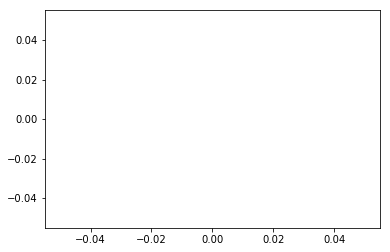

In [7]:
plt.plot(traj[:,0],traj[:,1])

In [8]:
# x = np.array([[-1.0,0.0],[0.0,1.0]])
# x = traj[[0, 999, 1999, 2999, 3999],:]
# t = np.array([0., 6.7/16])
x = np.array([[0., 0.], [0.5, -0.3], [1., 1.5], [1.5, .4], [2., .6]])
t = [0., 1., 2., 3., 4.]

In [9]:
gamma = np.array([.2,.25])

In [10]:
def brownianbridgeM(gvec, xin, tin, n):
    h = (tin[1]-tin[0])/n
    tvec = tin[0] + (1+np.arange(n))*h
    h12 = np.sqrt(h)
    wincs = np.random.multivariate_normal(mean=np.zeros(len(gvec)),
                                          cov=h*np.diag(np.square(gvec)),
                                          size=n)
    w = np.cumsum(wincs,axis=0).T
    bridge = xin[0,:,None] + w
    bridge -= ((tvec - tin[0])/(tin[1]-tin[0]))*(w[:,n-1,None] + xin[0,:,None] - xin[1,:,None])
    return tvec, bridge

In [11]:
# define drift function
def drift(x):
    f = np.zeros(x.shape)
    f[0,:] = x[1,:]
    f[1,:] = -np.sin(x[0,:])
    return f

In [12]:
xaux = np.array([[0.0,0.0],[0.0,0.0]])

In [13]:
# girsanov LOG likelihood
def girsanovM(gvec, path, dt):
    b = drift(path)
    u = np.dot(np.diag(np.power(gvec,-2)), b)
    int1 = np.tensordot(u[:,:-1], np.diff(path,axis=1))
    # int2 = np.tensordot(u, b)
    u2 = np.einsum('ij,ji->i',u.T,b)
    int2 = np.sum(0.5*(u2[1:] + u2[:-1]))*dt
    r = int1 - 0.5*int2
    return r

Acceptance rate during burn-in: 0.07
Acceptance rate post burn-in: 0.231
Acceptance rate during burn-in: 0.04
Acceptance rate post burn-in: 0.016
Acceptance rate during burn-in: 0.24
Acceptance rate post burn-in: 0.208
Acceptance rate during burn-in: 0.72
Acceptance rate post burn-in: 0.662


AttributeError: module 'matplotlib.pyplot' has no attribute 'zlabel'

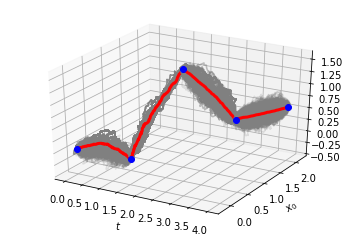

In [22]:
# MH sampler
numsteps = 1000
burnin = 100
n = 100
h = (t[1]-t[0])/n
fig = plt.figure()
ax = fig.gca(projection='3d')

# tout, xcur = brownianbridgeM(gamma,xaux,t,n)
# xcur += traj.T
for i in range(x.shape[0]-1):
    samples = np.zeros((2,numsteps,n))
    tout, xcur = brownianbridgeM(gamma,x[i:i+2],t[i:i+2],n)
    oldlik = girsanovM(gvec=gamma, path=xcur, dt=h)
    arburn = np.zeros(burnin)
    for jj in range(burnin):
        # _, prop = brownianbridgeM(gamma,xaux,t,n)
        # prop += traj.T
        _, prop = brownianbridgeM(gamma,x[i:i+2],t[i:i+2],n)
        proplik = girsanovM(gvec=gamma, path=prop, dt=h)
        rho = proplik - oldlik
        if (rho >= np.log(np.random.uniform())):
            xcur = prop
            oldlik = proplik
            arburn[jj] = 1

    print("Acceptance rate during burn-in:", np.mean(arburn))

    arsamp = np.zeros(numsteps)
    for jj in range(numsteps):
        # _, prop = brownianbridgeM(gamma,xaux,t,n)
        # prop += traj.T
        tout, prop = brownianbridgeM(gamma,x[i:i+2],t[i:i+2],n)
        proplik = girsanovM(gvec=gamma, path=prop, dt=h)
        rho = proplik - oldlik
        if (rho >= np.log(np.random.uniform())):
            xcur = prop
            oldlik = proplik
            arsamp[jj] = 1
        ax.plot(tout, xcur[0,:],xcur[1,:], color='grey', alpha=0.2)
        samples[:,jj,:] = xcur
    ax.plot(tout, np.mean(samples[0], axis=0), np.mean(samples[1], axis=0), 'r', linewidth=3)
    print("Acceptance rate post burn-in:", np.mean(arsamp))
# plt.vlines(t, -1, 1)
plt.plot(t, x[:, 0], x[:, 1], 'bo')
plt.grid()
plt.xlabel(r'$t$')
plt.ylabel(r'$x_0$')
plt.zlabel(r'$x_1$')
plt.show()

In [15]:
print(tout.shape)
print(tout[0])
tplot = np.zeros((1000, 100))
for i in range(1000):
    for j in range(100):
        tplot[i, j] = tout[j]

(100,)
3.01


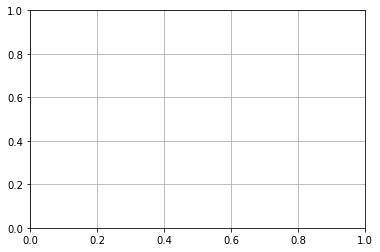

In [16]:


for i in range(100):
    ax.plot(tout, samples[0, i, :], samples[1, i, :], color='grey', alpha=0.2)
plt.grid()
ax.plot([t[3]], [x[3, 0]], [x[3, 1]], 'bo')
ax.plot([t[4]], [x[4, 0]], [x[4, 1]], 'bo')
ax.plot(tout, np.mean(samples[0], axis=0), np.mean(samples[1], axis=0), 'r', linewidth=3)
plt.show()

In [ ]:
samples

In [ ]:
[t[3]]